In [121]:
import cv2 as cv2
import numpy as np
from matplotlib import pyplot as plt
import random

# 1. Detecção de cantos.

## a) 

In [122]:
def HarrisCornerDetector(image, blockSize, ksize, k=0.06):
    # Converte para float e normaliza
    image = np.float32(image) / 255.0
    nlin, ncol = image.shape

    # Gradientes usando Sobel
    Ix = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=ksize)
    Iy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=ksize)

    # Produtos dos gradientes
    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy

    Rresult = np.zeros((nlin, ncol), dtype=np.float32)
    cont = 0

    for lin in range(blockSize, nlin - blockSize):
        for col in range(blockSize, ncol - blockSize):
            # Região local (janela)
            Ix2_block = Ix2[lin - blockSize:lin + blockSize + 1, col - blockSize:col + blockSize + 1]
            Iy2_block = Iy2[lin - blockSize:lin + blockSize + 1, col - blockSize:col + blockSize + 1]
            Ixy_block = Ixy[lin - blockSize:lin + blockSize + 1, col - blockSize:col + blockSize + 1]

            # Soma dos produtos
            Sxx = np.sum(Ix2_block)
            Syy = np.sum(Iy2_block)
            Sxy = np.sum(Ixy_block)

            # Determinante e traço
            det = Sxx * Syy - Sxy**2
            trace = Sxx + Syy

            # Equação de Harris
            R = det - k * (trace ** 2)

            Rresult[lin, col] = R
            if R > 0.01:
                cont += 1

    print("Pontos detectados:", cont)
    return Rresult

## b)

In [123]:
def NonMaximalSupression(im, window_size=3):
    nl, nc = im.shape
    maximos = []

    offset = window_size // 2

    for lin in range(offset, nl - offset):
        for col in range(offset, nc - offset):
            window = im[lin - offset:lin + offset + 1, col - offset:col + offset + 1]
            center_value = im[lin, col]

            if center_value == np.max(window) and center_value > 0.01:
                maximos.append((lin, col))
    
    return maximos


## c)

Pontos detectados: 14924


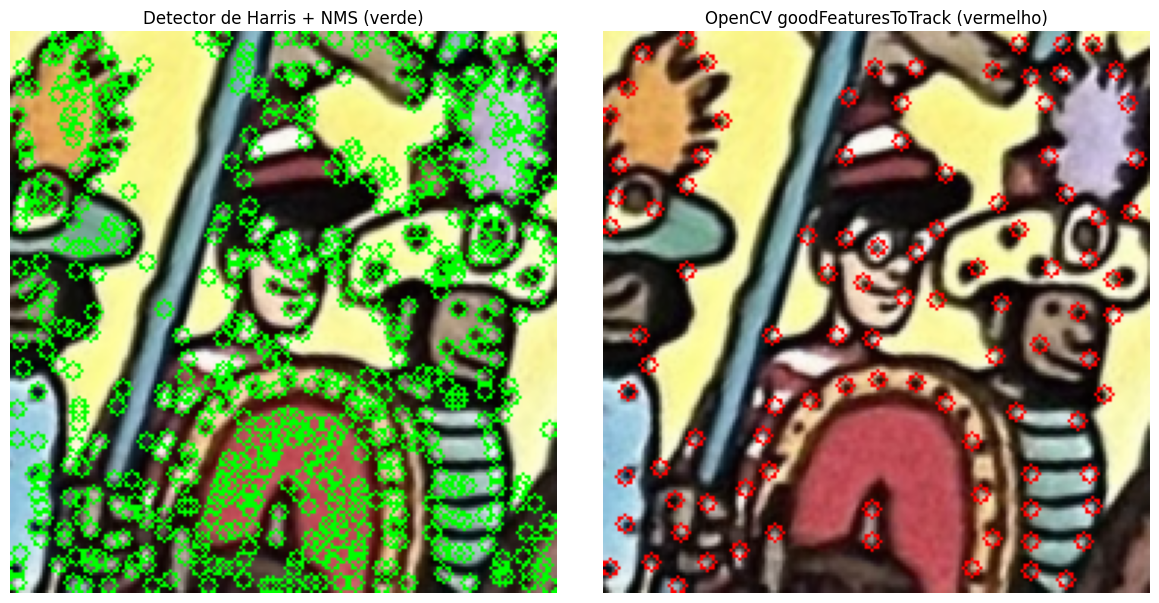

In [124]:

img_color = cv2.imread('Wally.png')  # troque pelo seu arquivo
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

R = HarrisCornerDetector(img_gray, blockSize=2, ksize=3)
cantos_harris = NonMaximalSupression(R, window_size=3)

img_harris = img_color.copy()
for (y, x) in cantos_harris:
    cv2.circle(img_harris, (x, y), 3, (0, 255, 0), 1)

corners_cv = cv2.goodFeaturesToTrack(img_gray, maxCorners=100, qualityLevel=0.01, minDistance=10)
img_cv = img_color.copy()
if corners_cv is not None:
    for pt in corners_cv:
        x, y = pt.ravel()
        cv2.circle(img_cv, (int(x), int(y)), 3, (0, 0, 255), 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Detector de Harris + NMS (verde)")
plt.imshow(cv2.cvtColor(img_harris, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("OpenCV goodFeaturesToTrack (vermelho)")
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

# 2. Patches e correspondência entre pontos.

In [125]:
def patch_correlation(patch1, patch2):
    p1 = patch1 - np.mean(patch1)
    p2 = patch2 - np.mean(patch2)
    numerator = np.sum(p1 * p2)
    denominator = np.sqrt(np.sum(p1 ** 2) * np.sum(p2 ** 2) + 1e-10)
    return numerator / denominator

In [126]:
def match_keypoints(img1, kp1, img2, kp2, patch_size=11, top_N=None):
    half = patch_size // 2
    matches = []

    for y1, x1 in kp1:
        if y1 - half < 0 or y1 + half >= img1.shape[0] or x1 - half < 0 or x1 + half >= img1.shape[1]:
            continue
        patch1 = img1[y1 - half:y1 + half + 1, x1 - half:x1 + half + 1]

        best_corr = -1
        best_match = None
        for y2, x2 in kp2:
            if y2 - half < 0 or y2 + half >= img2.shape[0] or x2 - half < 0 or x2 + half >= img2.shape[1]:
                continue
            patch2 = img2[y2 - half:y2 + half + 1, x2 - half:x2 + half + 1]
            corr = patch_correlation(patch1, patch2)

            if corr > best_corr:
                best_corr = corr
                best_match = (x2, y2)

        if best_match:
            matches.append(((x1, y1), best_match, best_corr))

    # Ordena pelos maiores valores de correlação e pega os top N
    matches.sort(key=lambda x: -x[2])  # decrescente
    if top_N is not None: 
        return matches[:top_N] 
    else: 
        return matches

In [127]:
img1_color = cv2.imread('im1.png')
img2_color = cv2.imread('im2.png')

img1_gray = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)

# Detectar cantos nas duas imagens
R1 = HarrisCornerDetector(img1_gray, blockSize=2, ksize=3)
R2 = HarrisCornerDetector(img2_gray, blockSize=2, ksize=3)

kp1 = NonMaximalSupression(R1, window_size=3)
kp2 = NonMaximalSupression(R2, window_size=3)


Pontos detectados: 35859
Pontos detectados: 8226


In [128]:
img1_show = cv2.cvtColor(img1_gray, cv2.COLOR_GRAY2BGR)
img2_show = cv2.cvtColor(img2_gray, cv2.COLOR_GRAY2BGR)

h1, w1 = img1_show.shape[:2]
h2, w2 = img2_show.shape[:2]
canvas_height = max(h1, h2)
canvas_width = w1 + w2
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

canvas[:h1, :w1] = img1_show
canvas[:h2, w1:] = img2_show

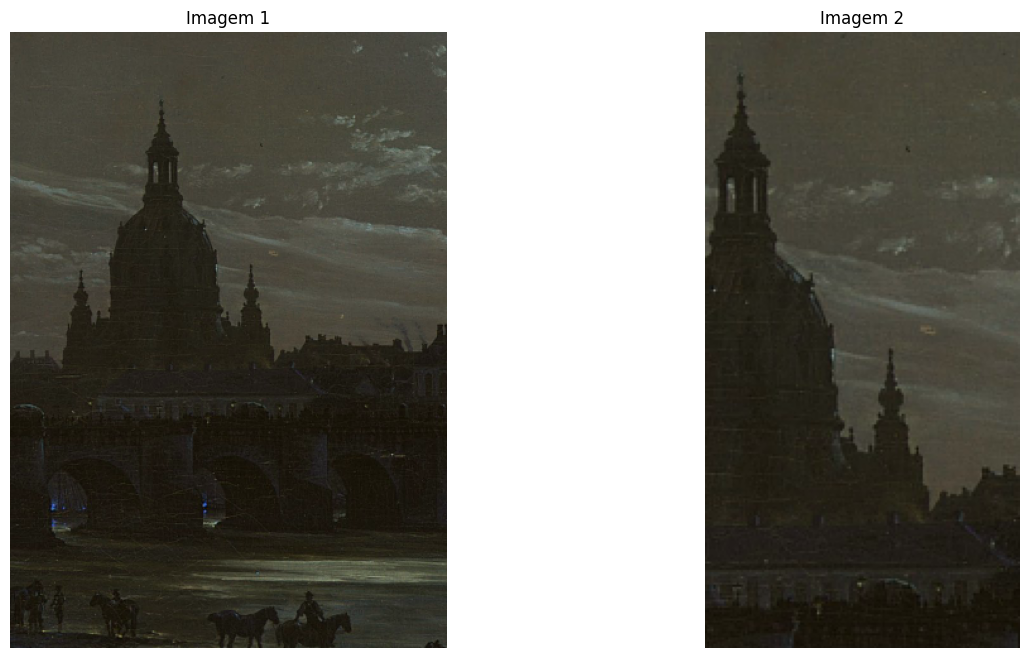

In [129]:
# Mostrar original
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(img1_color)
plt.axis('off')
plt.title("Imagem 1")

plt.subplot(1,2,2)
plt.imshow(img2_color)
plt.title("Imagem 2")
plt.axis('off')
plt.show()

In [130]:
top_N = 30 # Seleciona apenas os 30 melhores pontos casados para não poluir a imagem
matches = match_keypoints(img1_gray, kp1, img2_gray, kp2, patch_size=11, top_N=top_N)

for (x1, y1), (x2, y2), _ in matches:
    color = tuple(np.random.randint(0, 255, 3).tolist())
    pt1 = (x1, y1)
    pt2 = (x2 + w1, y2)
    cv2.circle(canvas, pt1, 4, color, 1)
    cv2.circle(canvas, pt2, 4, color, 1)
    cv2.line(canvas, pt1, pt2, color, 1)

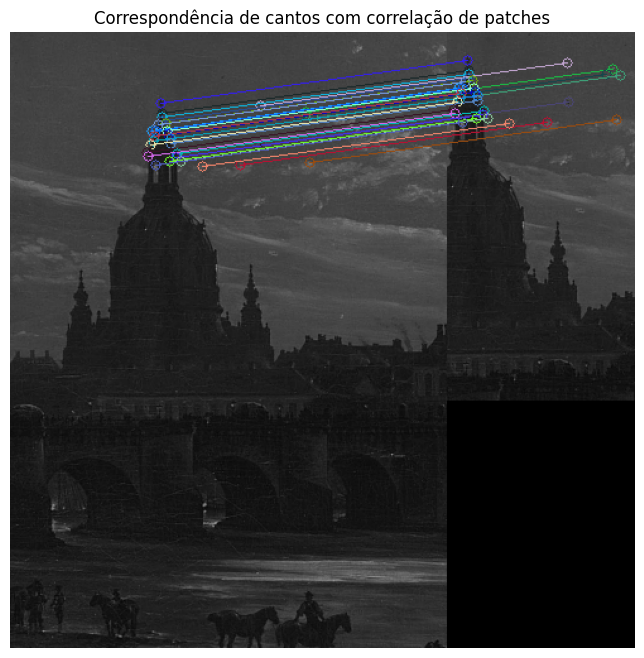

In [131]:

# Mostrar o resultado
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title("Correspondência de cantos com correlação de patches")
plt.axis('off')
plt.show()

# 3. Estimando por RANSAC

In [132]:
def compute_homography(p1, p2):
    """
    Estima H tal que p2 ≈ H @ p1
    p1 e p2 devem ser listas com 4 pontos [(x, y), ...]
    """
    A = []
    for (x, y), (xp, yp) in zip(p1, p2):
        A.append([-x, -y, -1, 0, 0, 0, x * xp, y * xp, xp])
        A.append([0, 0, 0, -x, -y, -1, x * yp, y * yp, yp])
    A = np.array(A)

    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    return H / H[2, 2]


In [133]:
def ransac_homography(matches, n_iters=1000, threshold=5):
    best_H = None
    best_inliers = []
    
    for _ in range(n_iters):
        # Seleciona 4 matches aleatórios
        sample = random.sample(matches, 4)
        pts1 = [m[0] for m in sample]
        pts2 = [m[1] for m in sample]

        try:
            H = compute_homography(pts1, pts2)
        except np.linalg.LinAlgError:
            continue

        inliers = []

        for pt1, pt2, _ in matches:
            p1 = np.array([pt1[0], pt1[1], 1.0])
            p2 = np.array([pt2[0], pt2[1], 1.0])

            p1_proj = H @ p1
            p1_proj /= p1_proj[2]

            error = np.linalg.norm(p2[:2] - p1_proj[:2])

            if error < threshold:
                inliers.append((pt1, pt2))

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_H = H

    print(f"Total inliers: {len(best_inliers)} / {len(matches)}")
    return best_H, best_inliers


In [134]:

matches = match_keypoints(img1_gray, kp1, img2_gray, kp2, patch_size=11)
matches_xy = [((x1, y1), (x2, y2), h) for ((x1, y1), (x2, y2), h) in matches]

# Estimar H
H, inliers = ransac_homography(matches_xy)

print("Matriz H estimada:")
print(H)

Total inliers: 64 / 1697
Matriz H estimada:
[[-1.82639237e-01 -2.24786754e-01  1.12000000e+02]
 [-2.13622679e-01 -2.62920221e-01  1.31000000e+02]
 [-1.63070748e-03 -2.00702459e-03  1.00000000e+00]]


# 4. Panorâmica

In [135]:
def calcular_homografia_custom(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # 1. Detecta cantos com Harris
    print("Detectando pontos de interesse com Harris...")
    harris_map1 = HarrisCornerDetector(gray1, blockSize=2, ksize=3)
    harris_map2 = HarrisCornerDetector(gray2, blockSize=2, ksize=3)
    
    # 2. Extrai os melhores pontos com Supressão Não-Máxima
    kp1 = NonMaximalSupression(harris_map1)
    kp2 = NonMaximalSupression(harris_map2)
    print(f"Encontrados {len(kp1)} keypoints na img1 e {len(kp2)} na img2.")

    # 3. Casa os keypoints usando correlação de patches
    print("Casando keypoints com correlação de patch...")
    # Usar top_N ajuda a alimentar o RANSAC apenas com as melhores correspondências
    matches = match_keypoints(gray1, kp1, gray2, kp2, patch_size=11, top_N=200)

    print("Calculando homografia com RANSAC...")
    H, inliers = ransac_homography(matches)

    return H, inliers
    

In [ ]:
def criar_panorama(path):
    img_esq = cv2.imread(f'{path}1.jpg')
    img_centro = cv2.imread(f'{path}2.jpg')
    img_dir = cv2.imread(f'{path}3.jpg')
    img_esq_rgb = cv2.cvtColor(img_esq, cv2.COLOR_BGR2RGB)
    img_centro_rgb = cv2.cvtColor(img_centro, cv2.COLOR_BGR2RGB)
    img_dir_rgb = cv2.cvtColor(img_dir, cv2.COLOR_BGR2RGB)
    fator_escala = 0.4

    img_esq_pequena = cv2.resize(img_esq, (0, 0), fx=fator_escala, fy=fator_escala)
    img_centro_pequena = cv2.resize(img_centro, (0, 0), fx=fator_escala, fy=fator_escala)
    img_dir_pequena = cv2.resize(img_dir, (0, 0), fx=fator_escala, fy=fator_escala)
    
    print("--- Processando Esquerda -> Centro (em baixa resolução) ---")
    H_pequena_esq, _ = calcular_homografia_custom(img_esq_pequena, img_centro_pequena)

    print("\n--- Processando Direita -> Centro (em baixa resolução) ---")
    H_pequena_dir, _ = calcular_homografia_custom(img_dir_pequena, img_centro_pequena)

    if H_pequena_esq is not None and H_pequena_dir is not None:
        S = np.array([[fator_escala, 0, 0], [0, fator_escala, 0], [0, 0, 1]])
        S_inv = np.linalg.inv(S)

        print("\nAjustando homografias para a escala original...")
        H_esq_centro = S_inv @ H_pequena_esq @ S
        H_dir_centro = S_inv @ H_pequena_dir @ S

        h_esq, w_esq = img_esq.shape[:2]
        h_centro, w_centro = img_centro.shape[:2]
        h_dir, w_dir = img_dir.shape[:2]
        pts_esq = np.float32([[0, 0], [0, h_esq], [w_esq, h_esq], [w_esq, 0]]).reshape(-1, 1, 2)
        pts_centro = np.float32([[0, 0], [0, h_centro], [w_centro, h_centro], [w_centro, 0]]).reshape(-1, 1, 2)
        pts_dir = np.float32([[0, 0], [0, h_dir], [w_dir, h_dir], [w_dir, 0]]).reshape(-1, 1, 2)
        
        pts_esq_transformados = cv2.perspectiveTransform(pts_esq, H_esq_centro)
        pts_dir_transformados = cv2.perspectiveTransform(pts_dir, H_dir_centro)
        
        todos_os_pontos = np.concatenate((pts_centro, pts_esq_transformados, pts_dir_transformados), axis=0)
        [x_min, y_min] = np.int32(todos_os_pontos.min(axis=0).ravel() - 0.5)
        [x_max, y_max] = np.int32(todos_os_pontos.max(axis=0).ravel() + 0.5)
        largura_final = x_max - x_min
        altura_final = y_max - y_min
        print(f"Tamanho da tela final: {largura_final}x{altura_final}")

        matriz_translacao = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float32)
        
        panorama = cv2.warpPerspective(img_esq_rgb, matriz_translacao.dot(H_esq_centro), (largura_final, altura_final))
        img_dir_deformada = cv2.warpPerspective(img_dir_rgb, matriz_translacao.dot(H_dir_centro), (largura_final, altura_final))
        
        panorama = np.maximum(panorama, img_dir_deformada)
        img_centro_deformada = cv2.warpPerspective(img_centro_rgb, matriz_translacao, (largura_final, altura_final))
        mascara_centro = cv2.cvtColor(img_centro_deformada, cv2.COLOR_RGB2GRAY)
        _, mascara_centro = cv2.threshold(mascara_centro, 0, 255, cv2.THRESH_BINARY)
        panorama[mascara_centro > 0] = img_centro_deformada[mascara_centro > 0]

        plt.figure(figsize=(20, 10))
        plt.imshow(panorama)
        plt.title('Panorama Final')
        plt.axis('off')
        plt.show()
    else:
        print("\nNão foi possível calcular uma ou mais homografias. O panorama não pode ser gerado.")


--- Processando Esquerda -> Centro (em baixa resolução) ---
Detectando pontos de interesse com Harris...
Pontos detectados: 30655
Pontos detectados: 30492
Encontrados 1520 keypoints na img1 e 1534 na img2.
Casando keypoints com correlação de patch...
Calculando homografia com RANSAC...
Total inliers: 120 / 200

--- Processando Direita -> Centro (em baixa resolução) ---
Detectando pontos de interesse com Harris...
Pontos detectados: 31054
Pontos detectados: 30492
Encontrados 1583 keypoints na img1 e 1534 na img2.
Casando keypoints com correlação de patch...
Calculando homografia com RANSAC...
Total inliers: 117 / 200

Ajustando homografias para a escala original...
Tamanho da tela final: 1475x677


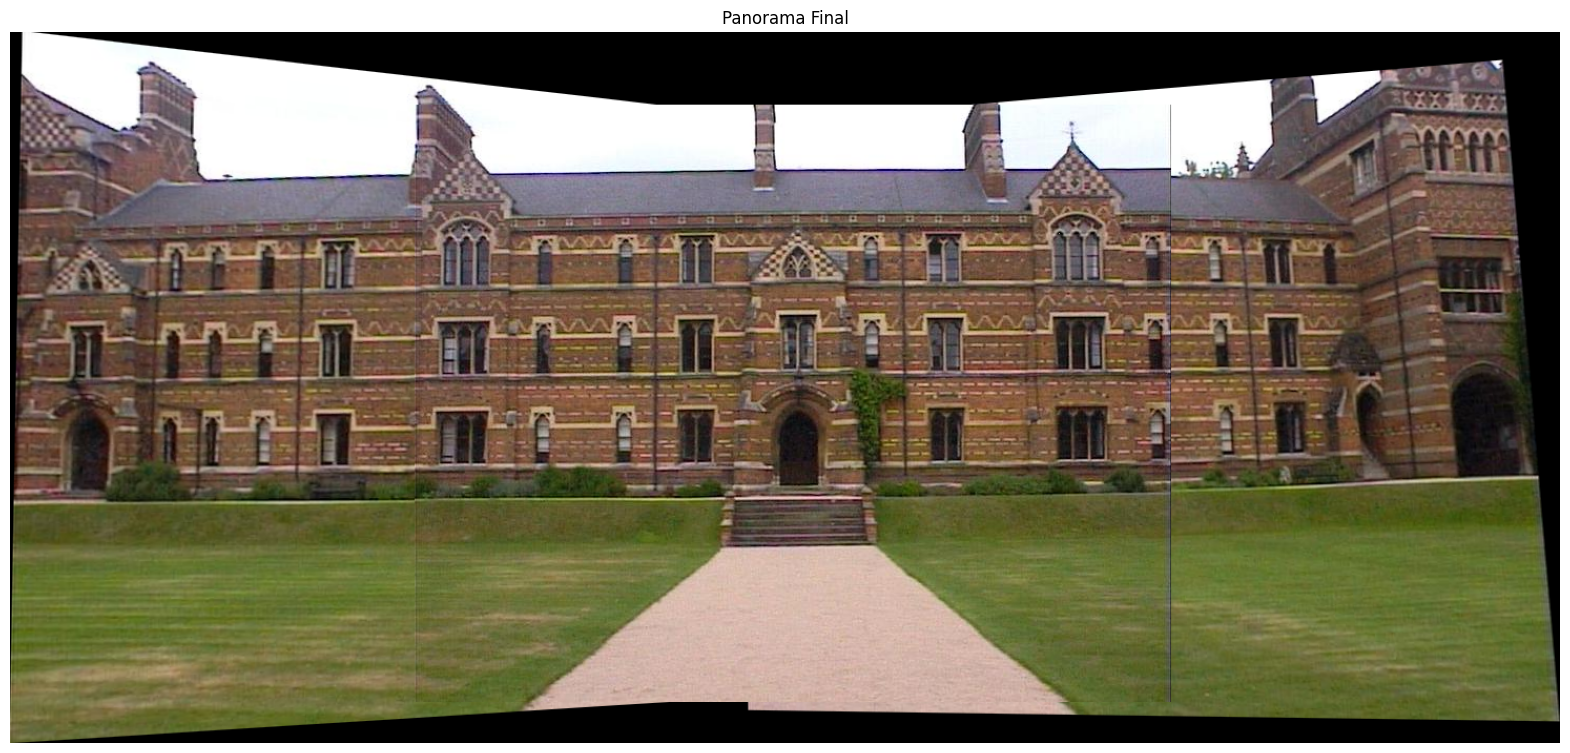

In [137]:
criar_panorama('keble_')